# Willflix
This notebook explores using the top film lists with Recommender Systems to infer if we can find structure within them.

## Setup


In [12]:
from pathlib import Path

import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import plotly.express as px

from model import MatrixFactorizationExplicitFeedback, fit_mf

In [2]:
WILL_DATA_PATH = Path("data") / "raw" / "Our Best Films of the 21st Century - Lists.csv"

## Data Prep

In [75]:
df["global_film_score"] = df.groupby("Film")["Score"].transform("sum")
df

,Rank,Lister,Film,Director,Year,Score,# of lists,68,global_film_score,score_normalized,lister_idx,film_idx
0,1,Aidan,Treasure Planet,Ron Clements & John Musker,2002,35,NaN,NaN,78,1.000000,0,529
1,2,Aidan,The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,2001,32,NaN,NaN,600,0.914286,0,478
2,3,Aidan,No Country for Old Men,Joel & Ethan Coen,2007,29,NaN,NaN,343,0.828571,0,306
3,4,Aidan,Hell or High Water,David Mackenzie,2016,26,NaN,NaN,81,0.742857,0,190
4,5,Aidan,Fantastic Mr. Fox,Wes Anderson,2009,24,NaN,NaN,211,0.685714,0,156
...,...,...,...,...,...,...,...,...,...,...,...,...
1549,21,Zach G,The Lord of the Rings: The Return of the King,Peter Jackson,2003,5,NaN,NaN,409,0.142857,67,479
1550,22,Zach G,Napoleon Dynamite,Jared Hess,2004,4,NaN,NaN,53,0.114286,67,301
1551,23,Zach G,Captain Phillips,Paul Greengrass,2013,3,NaN,NaN,3,0.085714,67,94
1552,24,Zach G,"Monsters, Inc.",Pete Docter,2001,2,NaN,NaN,93,0.057143,67,290


In [80]:
df = pd.read_csv(WILL_DATA_PATH)

# Did will already handle scoring with less films on a listers list? I'll assume so.
# Just normalize to (0, 1),
df["global_film_score"] = df.groupby("Film")["Score"].transform("sum")
df["film_number_of_lists"] = df.groupby("Film")["Lister"].transform("nunique")

df["score_normalized"] = df["Score"] / df.groupby("Lister")["Score"].transform("max")
lister_labeller = LabelEncoder()
df["lister_idx"] = lister_labeller.fit_transform(df["Lister"])
film_labeller = LabelEncoder()
df["film_idx"] = film_labeller.fit_transform(df["Film"])

df[["Lister", "lister_idx", "Film", "film_idx", "Score", "score_normalized"]].head()

,Lister,lister_idx,Film,film_idx,Score,score_normalized
0,Aidan,0,Treasure Planet,529,35,1.000000
1,Aidan,0,The Lord of the Rings: The Fellowship of the Ring,478,32,0.914286
2,Aidan,0,No Country for Old Men,306,29,0.828571
3,Aidan,0,Hell or High Water,190,26,0.742857
4,Aidan,0,Fantastic Mr. Fox,156,24,0.685714


In [85]:
# UGH env mismatches between mp and torch
viewers = torch.tensor(df["lister_idx"].astype(float)).to(int)
films = torch.tensor(df["film_idx"].astype(float)).to(int)
scores = torch.tensor(df["score_normalized"])

viewers_unique = torch.tensor(df["lister_idx"].unique().astype(float)).to(int)
films_unique = torch.tensor(df["film_idx"].unique().astype(float)).to(int)

# Exclude films on a single list
films_plural_unique = torch.tensor(df.loc[df["film_number_of_lists"] > 1, "film_idx"].unique().astype(float)).to(int)


## Model

Fitting Model with 2 dimensions.
Stopping at 625 as loss has halted at 0.022173.
Fitting Model with 6 dimensions.


/var/folders/15/05knpnr51lj1sbhrslpf21rc0000gp/T/ipykernel_24895/813981176.py:22: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Stopping at 650 as loss has halted at 0.001240.
Fitting Model with 10 dimensions.
Stopping at 325 as loss has halted at 0.000342.
Fitting Model with 14 dimensions.
Stopping at 200 as loss has halted at 0.000289.
Fitting Model with 18 dimensions.
Stopping at 200 as loss has halted at 0.000251.
Fitting Model with 22 dimensions.
Stopping at 175 as loss has halted at 0.000246.
Fitting Model with 26 dimensions.
Stopping at 150 as loss has halted at 0.000242.
Fitting Model with 30 dimensions.
Stopping at 150 as loss has halted at 0.000232.
Fitting Model with 34 dimensions.
Stopping at 150 as loss has halted at 0.000226.
Fitting Model with 38 dimensions.
Stopping at 150 as loss has halted at 0.000222.
Fitting Model with 42 dimensions.
Stopping at 150 as loss has halted at 0.000219.
Fitting Model with 46 dimensions.
Stopping at 150 as loss has halted at 0.000217.


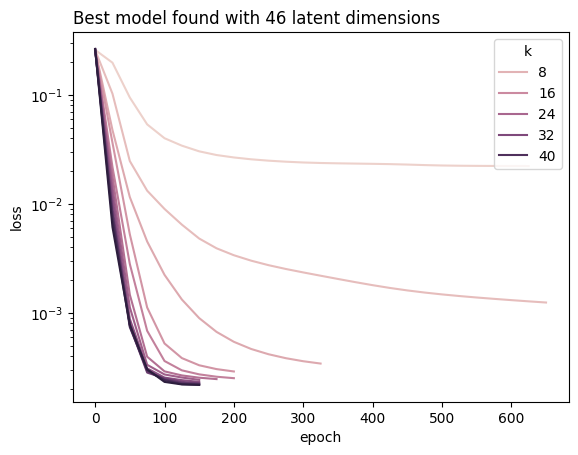

In [5]:
best_loss = float("inf")
best_k = 0
best_model = None
loss_series = pd.DataFrame(columns=["epoch", "loss", "k"])

for potential_k in range(2, 50, 4):
    print(f"Fitting Model with {potential_k} dimensions.")
    explicit_feedback_mf_model = MatrixFactorizationExplicitFeedback(
        num_movies = df["Film"].nunique(),
        num_viewers = df["Lister"].nunique(),
        k_embed_dims = potential_k
    )
    losses = fit_mf(
        model=explicit_feedback_mf_model,
        user_ids=viewers,
        item_ids=films,
        ratings=scores,
        epochs=10000,
        early_stopping_tolerance=0.0001,
        epoch_check_every=25
    )
    loss_series = pd.concat(
        [
            loss_series, 
            pd.DataFrame(losses).rename(columns={0: "epoch", 1: "loss"}).assign(k=potential_k)
        ], axis="rows"
    )
    _, final_loss = losses[-1]
    if final_loss < best_loss:
        best_loss = final_loss
        best_k = potential_k
        best_model = explicit_feedback_mf_model


sns.lineplot(
    loss_series,
    x="epoch",
    y="loss",
    hue="k"
)
plt.title(f"Best model found with {best_k} latent dimensions", loc="left")
plt.yscale('log')
plt.show()

## Explore Results

In [6]:
def lookup_cosine_similarity(
    my_item_name: str, 
    my_item_labeller: LabelEncoder, 
    my_item_embeddings: torch.nn.Embedding, 
    other_items: torch.Tensor, 
    other_item_labeller: LabelEncoder, 
    other_item_embeddings: torch.nn.Embedding, 
    k: int=5
) -> pd.DataFrame:
    """
    Create a dataframe of the top k, bottom k, and middle k other items with cosine similarity 
    in comparison to the embedding of my item.
    """
    item_idx = torch.tensor(my_item_labeller.transform([my_item_name]).astype(float)).to(int)
    item_similarities = cosine_similarity(
        my_item_embeddings(item_idx),
        other_item_embeddings(other_items),
        # dim=1
    )

    item_sim_display = (
        pd.DataFrame(
            [
                other_items.detach().tolist(), 
                item_similarities.detach().tolist()
            ],
        )
        .T
        .rename(columns={0:"item_idx", 1:"cosine_similarity"})
        .drop_duplicates()
        .sort_values("cosine_similarity", ascending=False)
    )
    item_sim_display["item"] = other_item_labeller.inverse_transform(item_sim_display["item_idx"].astype(int))
    item_sim_display = item_sim_display.loc[item_sim_display["item"] != my_item_name]

    n_records = len(item_sim_display)
    idx_selector = list(range(0, k)) + list(range(n_records // 2, (n_records//2)+k)) + list(range(n_records-k, n_records))
    item_sim_display = item_sim_display.iloc[idx_selector][["item", "cosine_similarity"]]
    return item_sim_display

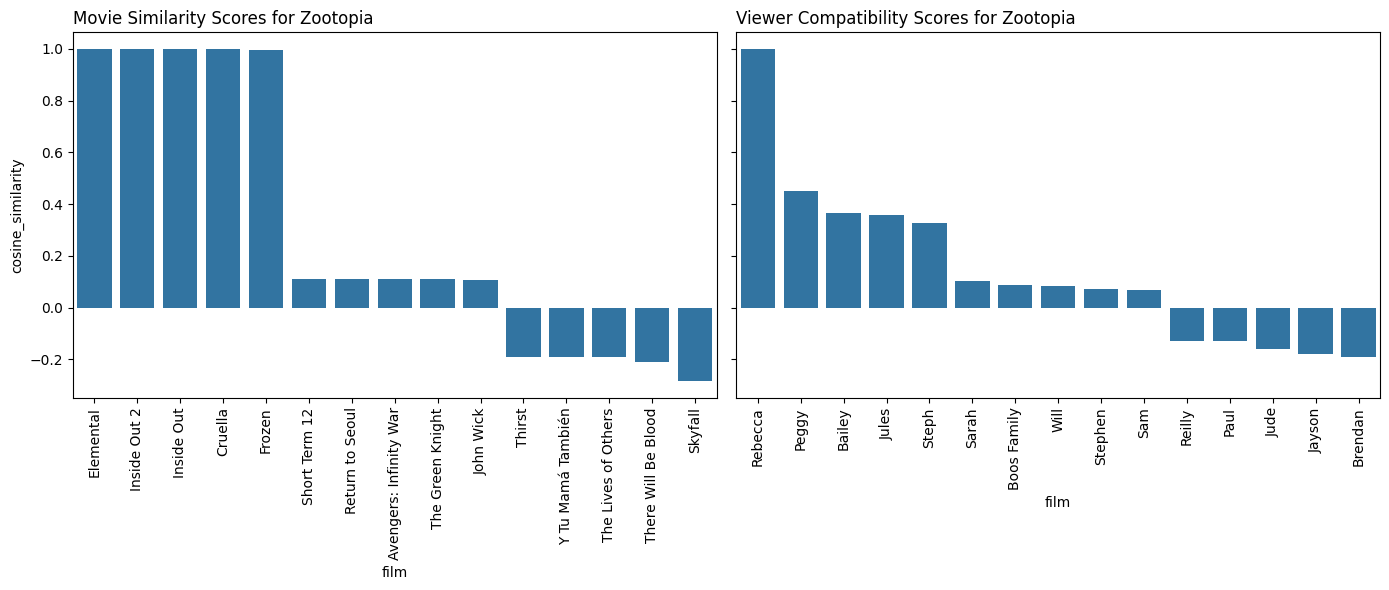

In [46]:
FILM = "Zootopia"

# Film-Film Similairty
film_film_comparison = lookup_cosine_similarity(
    my_item_name = FILM,
    my_item_labeller= film_labeller,
    my_item_embeddings = best_model.movie_emb,
    other_items = films,
    other_item_labeller = film_labeller,
    other_item_embeddings = best_model.movie_emb
).rename(columns={"item": "film"})
film_viewer_comparison = lookup_cosine_similarity(
    my_item_name = FILM,
    my_item_labeller=  film_labeller,
    my_item_embeddings = best_model.movie_emb,
    other_items = viewers,
    other_item_labeller = lister_labeller,
    other_item_embeddings = best_model.viewer_emb
).rename(columns={"item": "film"})

f, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.barplot(
    film_film_comparison,
    x="film",
    y="cosine_similarity",
    ax=ax[0]
)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title(f"Movie Similarity Scores for {FILM}", loc="left", size=12)

sns.barplot(
    film_viewer_comparison,
    x="film",
    y="cosine_similarity",
    ax=ax[1]
)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title(f"Viewer Compatibility Scores for {FILM}", loc="left", size=12)

plt.tight_layout()
plt.show()

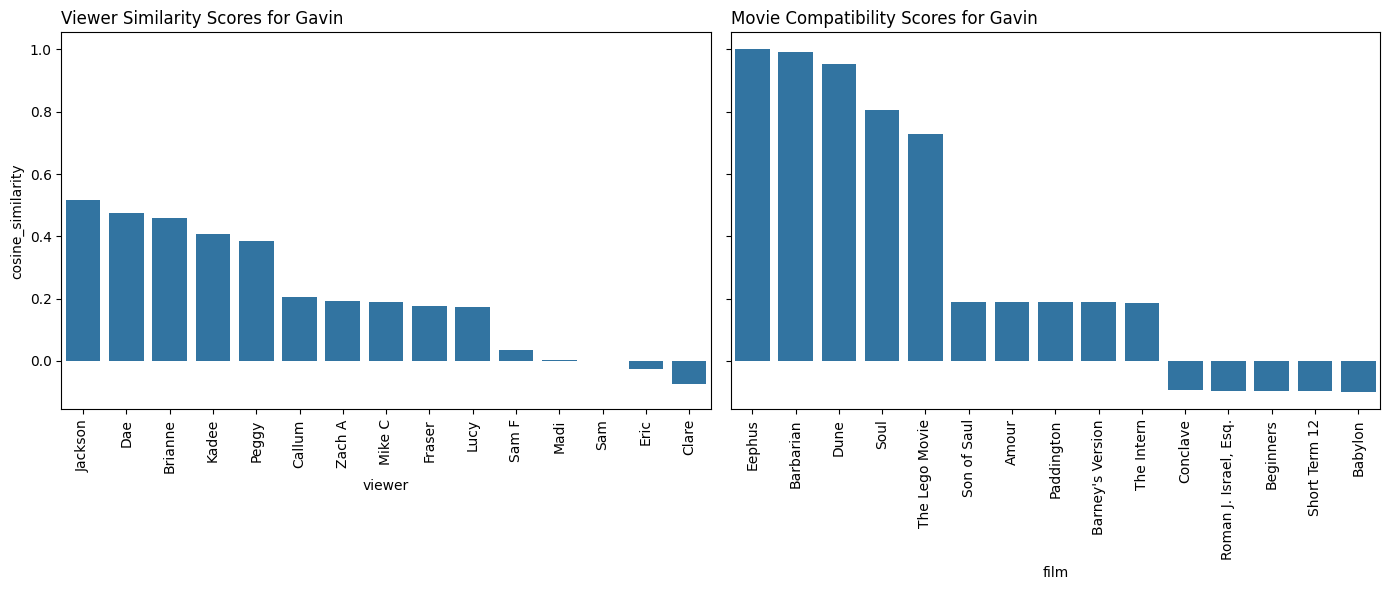

In [107]:
VIEWER = "Gavin"

# Viewer-Viewer Similairty
viewer_viewer_comparison = lookup_cosine_similarity(
    my_item_name = VIEWER,
    my_item_labeller=  lister_labeller,
    my_item_embeddings = best_model.viewer_emb,
    other_items = viewers,
    other_item_labeller = lister_labeller,
    other_item_embeddings = best_model.viewer_emb
).rename(columns={"item": "viewer"})
viewer_film_comparison = lookup_cosine_similarity(
    my_item_name = VIEWER,
    my_item_labeller=  lister_labeller,
    my_item_embeddings = best_model.viewer_emb,
    other_items = films,
    other_item_labeller = film_labeller,
    other_item_embeddings = best_model.movie_emb
).rename(columns={"item": "film"})

f, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.barplot(
    viewer_viewer_comparison,
    x="viewer",
    y="cosine_similarity",
    ax=ax[0]
)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title(f"Viewer Similarity Scores for {VIEWER}", loc="left", size=12)

sns.barplot(
    viewer_film_comparison,
    x="film",
    y="cosine_similarity",
    ax=ax[1]
)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title(f"Movie Compatibility Scores for {VIEWER}", loc="left", size=12)

plt.tight_layout()
plt.show()

In [101]:
# Movies

reducer = umap.UMAP(n_components=3)

film_embeddings = best_model.movie_emb(films_plural_unique)
films_umap = reducer.fit_transform(np.array(film_embeddings.detach().tolist()))

film_viz_data = pd.DataFrame(films_umap)
film_viz_data["film_idx"] = films_plural_unique.detach().tolist()
film_viz_data["film"] = film_labeller.inverse_transform(film_viz_data["film_idx"])
film_viz_data_aug = pd.merge(
    film_viz_data,
    df[["Film", "global_film_score"]].drop_duplicates(),
    left_on="film",
    right_on="Film"
)
fig = px.scatter(
    film_viz_data_aug,
    x=0,
    y=1,
    hover_name="film",
    color="global_film_score",
    size="global_film_score"
)
# fig.update_traces(marker=dict(size=6, line=dict(width=1)))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig


In [104]:
# Viewers
reducer = umap.UMAP(n_components=3)

viewer_embeddings = best_model.viewer_emb(viewers_unique)
viewers_umap = reducer.fit_transform(np.array(viewer_embeddings.detach().tolist()))

viewer_viz_data = pd.DataFrame(viewers_umap)
viewer_viz_data["viewer_idx"] = viewers_unique.detach().tolist()
viewer_viz_data["viewer"] = lister_labeller.inverse_transform(viewer_viz_data["viewer_idx"])
viewer_viz_data_aug = pd.merge(
    viewer_viz_data,
    df[["Lister"]].drop_duplicates(),
    left_on="viewer",
    right_on="Lister"
)
fig = px.scatter(
    viewer_viz_data_aug,
    x=0,
    y=1,
    hover_name="viewer",
)
# fig.update_traces(marker=dict(size=6, line=dict(width=1)))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig
